In [306]:
import numpy as np
from scanf import scanf
from datetime import datetime, timedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [119]:
'''
NOTE: This method is specifically for the OpenBCI input format.

path: full path of data file
granularity: keep every x data points
channels: array of channels to keep (zero-indexed)
dataLimit: keep up to the xth data point total
'''
def getData(path, granularity, channels, dataLimit):
	dataRaw = []
	dataStartLine = 6
	count = 0
	with open(path, 'r') as data_file:
		for line in data_file:
			if count >= dataStartLine:
					dataRaw.append(line.strip().split(','))
			else:
					count += 1
	dataRaw = np.char.strip(np.array(dataRaw))

	dataChannels = dataRaw[:, 1:5]
	timeChannels = dataRaw[:, 15]

	if granularity is None:
		granularity = 1
	# the current channel of data
	if dataLimit is None:
		dataLimit = len(dataChannels)

	channelData = dataChannels[:,channels][:dataLimit:granularity].transpose()
	y_channels = channelData.astype(float)
	inds = np.arange(channelData.shape[1])
	t = np.array([datetime.strptime(time[11:],'%H:%M:%S.%f') for time in timeChannels])
	return y_channels,inds,t

In [258]:
'''
This groups each data point in a ~1 second interval. We can perform analysis involving averages, std devs etc on each 
of these groups and give them labels.
If a treat was shown any time during the interval, it is labeled as treat. Otherwise we label it as no-treat

Takes in a data tuple:
data -> (y_channels, inds, t)

y_channels -> [chan0, chan1, chan2, chan3, ...] Each chan is an array of voltages
inds -> indicies of each data point. These are aligned with the values in each chan array and the t array
t -> times of each data point
'''
def groupbyInterval(data, labels, interval):
	#data tuple (x,y,z). labels: datetimes. interval(ms): int
	y_channels,inds,t = data
	interval_ms = timedelta(milliseconds=interval)
	
	split_inds = []
	cutoff_times = [t[0]+interval_ms]
	for ind in range(t.shape[0]):
		time = t[ind]
		if time >= cutoff_times[-1]:
			split_inds.append(ind)
			cutoff_times.append(cutoff_times[-1] + interval_ms)
	
	ind_groups = np.split(inds, split_inds)
	y_channels_groups = np.split(y_channels, split_inds, axis=1)
	t_groups = np.split(t, split_inds)

	#find min group size
	min_group_size = ind_groups[0].shape[0]
	cutinds = []
	for i in range(len(split_inds)-1):
		if ind_groups[i].shape[0] < 150:
			cutinds.append(i)
		elif ind_groups[i].shape[0] < min_group_size:
			min_group_size = ind_groups[i].shape[0]

	#rectangularize jagged arrays
	for i in range(len(split_inds)):
		ind_groups[i] = ind_groups[i][:min_group_size]
		y_channels_groups[i] = y_channels_groups[i][:,:min_group_size]

	#drop short last group
	ind_groups = [ind_groups[i] for i in range(len(ind_groups)) if i not in cutinds]
	ind_groups = np.array(ind_groups[:-1])
	y_channels_groups = [y_channels_groups[i] for i in range(len(y_channels_groups)) if i not in cutinds]
	y_channels_groups = np.array(y_channels_groups[:-1]).transpose((1,0,2))
	t_groups = [t_groups[i] for i in range(len(t_groups)) if i not in cutinds]
	t_groups = np.array(t_groups[:-1])

	cutoff_times = [cutoff_times[i] for i in range(len(cutoff_times)) if i not in cutinds]

	#assign labels to groups
	# TODO: CHECK IF LABEL MATCHING IS CORRECT
	NO_TREAT = 0
	TREAT = 1
		
	l_groups = np.array([NO_TREAT] * ind_groups.shape[0])
	
	lnum=0
	for ind in range(l_groups.shape[0]):
		if lnum==len(labels):
			break

		cutoff = cutoff_times[ind]
		start = cutoff - interval_ms
		if labels[lnum][0] == TREAT and start <= labels[lnum+1][1] and labels[lnum][1] > cutoff:
			l_groups[ind] = TREAT

				
		else:
			lnum+=1
	
	return y_channels_groups, ind_groups, t_groups, l_groups, y_channels

[(0, datetime.datetime(1900, 1, 1, 21, 18, 41, 836212)),
 (1, datetime.datetime(1900, 1, 1, 21, 19, 6, 835099)),
 (0, datetime.datetime(1900, 1, 1, 21, 19, 41, 1644)),
 (1, datetime.datetime(1900, 1, 1, 21, 20, 51, 171674)),
 (0, datetime.datetime(1900, 1, 1, 21, 21, 21, 781487)),
 (1, datetime.datetime(1900, 1, 1, 21, 22, 23, 77201)),
 (0, datetime.datetime(1900, 1, 1, 21, 22, 56, 229613)),
 (1, datetime.datetime(1900, 1, 1, 21, 24, 47, 402283)),
 (0, datetime.datetime(1900, 1, 1, 21, 25, 10, 884783)),
 (1, datetime.datetime(1900, 1, 1, 21, 26, 35, 633614)),
 (0, datetime.datetime(1900, 1, 1, 21, 27, 10, 442693)),
 (1, datetime.datetime(1900, 1, 1, 21, 29, 15, 142540)),
 (0, datetime.datetime(1900, 1, 1, 21, 29, 37, 448052)),
 (1, datetime.datetime(1900, 1, 1, 21, 30, 25, 456958)),
 (0, datetime.datetime(1900, 1, 1, 21, 31, 8, 826718)),
 (1, datetime.datetime(1900, 1, 1, 21, 32, 5, 879538)),
 (0, datetime.datetime(1900, 1, 1, 21, 32, 48, 841227)),
 (1, datetime.datetime(1900, 1, 1, 21

In [155]:
t_groups

array([[datetime.datetime(1900, 1, 1, 21, 18, 31, 414000)],
       [datetime.datetime(1900, 1, 1, 21, 18, 32, 417000)],
       [datetime.datetime(1900, 1, 1, 21, 18, 33, 422000)],
       ...,
       [datetime.datetime(1900, 1, 1, 21, 38, 41, 423000)],
       [datetime.datetime(1900, 1, 1, 21, 38, 42, 430000)],
       [datetime.datetime(1900, 1, 1, 21, 38, 43, 419000)]], dtype=object)

In [163]:
labels = []
with open("data/cauchy/2022-03-30_Cauchy0/labels.txt") as f:
    lines = f.readlines()
    for line in lines:
        label, yr,mo,dy,hr,m,s,ns = scanf("(%d, datetime.datetime(%d, %d, %d, %d, %d, %d, %d)", line)
        labels.append((label, datetime(1900,1,1,hr,m,s,ns)))

data = getData("data/cauchy/2022-03-30_Cauchy0/OpenBCI-RAW-2022-03-30_21-18-31.txt", None, [3], None)


In [259]:
y_channels_groups, ind_groups, t_groups, l_groups, y_channels = groupbyInterval(data, labels, 1000)

In [294]:
train_inds, test_inds = train_test_split(np.arange(ind_groups.shape[0]), test_size=.2)

trainX = y_channels_groups[:, train_inds, :].reshape((904,191))
trainL = l_groups[train_inds]
testX = y_channels_groups[:, test_inds, :].reshape((226,191))
testL = l_groups[test_inds]


In [296]:
train_means = trainX.mean(axis=1)
train_stdevs = trainX.std(axis=1)

test_means = testX.mean(axis=1)
test_stdevs = testX.std(axis=1)

In [300]:
knn = KNeighborsClassifier(3)
train_all = np.array([train_means, train_stdevs]).T
knn.fit(train_all, trainL)

KNeighborsClassifier(n_neighbors=3)

In [304]:
test_all = np.array([test_means, test_stdevs]).T
test_predict = knn.predict(test_all)
confusion_matrix(testL, test_predict)

array([[ 12,   9],
       [  4, 201]])

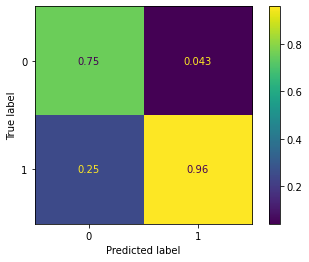

In [310]:
ConfusionMatrixDisplay.from_predictions(testL, test_predict, normalize="pred")